In [26]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time

import xlrd
import numpy as np
import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

**Linear Regression**

Inference: $\hat{y} = wx + b$

MSE: $E[(y - \hat{y})^2]$

In [2]:
## OLD

# 1. Assemble the graph 
# ----------------------

# 1.1 Read the data from .xls file
DATA_FILE = './data/fire_theft.xls'
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# 1.2 Create placeholders for input X (number of incidents of fire) and label Y (number of incidents of theft)
X = tf.placeholder(dtype=tf.float32, name='X')
Y = tf.placeholder(dtype=tf.float32, name='Y')

# 1.3 Create Variables for weight and bias, initialized to 0.0
w = tf.Variable(initial_value=0.0, name='w')
b = tf.Variable(initial_value=0.0, name='b')

# 1.4 Predict Y: Y_pred = w * X + b
Y_pred = tf.add(tf.multiply(w, X), b)

# 1.5 Specify loss function: (Y_pred - Y)^2
cost = tf.square(Y - Y_pred, name='cost')

# 1.6 Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

In [3]:
# 2. Train the model
# ------------------

# Session looks at all trainable variables that loss depends on and updates them
with tf.Session() as sess:
    
    # 2.1 Initialize the nessary variables
    sess.run(tf.global_variables_initializer())
    
    # Write file for tensorboard
    writer = tf.summary.FileWriter('./graphs/linear_reg', sess.graph)
    
    # 2.2 Training
    for i in range(100): # Number of epochs
        total_cost = 0
        for x, y in data:
            _, c = sess.run([optimizer, cost], feed_dict={X: x, Y: y})
            total_cost += c
        if i % 10 == 0:
            print("Epoch {0}: Loss: {1}".format(i, total_cost/float(n_samples)))
            
    # Close writer
    writer.close()
    
    # Output the values variables w and b
    w_hat, b_hat = sess.run([w, b])
    
# NOTE: learning_rate = 0.01 causes NaN problem

Epoch 0: Loss: 2069.63207797
Epoch 10: Loss: 1924.59308791
Epoch 20: Loss: 1773.10248388
Epoch 30: Loss: 1666.19347014
Epoch 40: Loss: 1589.66804057
Epoch 50: Loss: 1534.21181074
Epoch 60: Loss: 1493.60021142
Epoch 70: Loss: 1463.59953585
Epoch 80: Loss: 1441.27846243
Epoch 90: Loss: 1424.57485955


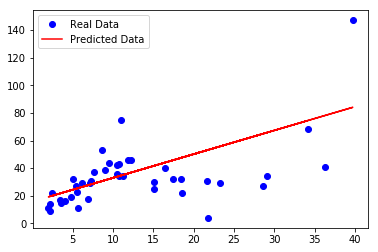

In [4]:
# Plot the results    
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real Data')
plt.plot(X, X * w_hat + b_hat, 'r', label='Predicted Data')
plt.legend()
plt.show()

Data shown above has outliers. Square loss is tendency to be dominated by outliers.

**Huber Loss** - Robust to outliers. 

Intuition - If the difference between the predicted value and the real value is small, then square the it, if the difference is large, then take its absolute value

$$L_{\delta}(y, f(x)) = \begin{cases}
                          \frac{1}{2}(y-f(x))^2 & \text{for}\ \left|y-f(x)\right| \leq \delta \\
                          \delta\left|y-f(x)\right| -\frac{1}{2}\delta^2 & \text{otherwise}
                        \end{cases}$$
                        
**NOTE: ** In TensorFlow `if Y - Y_predicted < delta:` statement is not posible

In [5]:
def huber_loss(Y_true, Y_pred, delta=1.0):
    """
    Huber loss function
    """
    # Calculate absolute residual
    residual = tf.abs(Y_pred - Y_true)
    
    # Condition to evaluate
    condition = tf.less_equal(residual, delta)
    
    # Residual <= delta
    small_residual = 0.5 * tf.square(residual)
    
    # Residual > delta
    large_residual = delta * residual - 0.5 * tf.square(delta)
    
    return tf.where(condition, x=small_residual, y=large_residual)

In [6]:
# 1. Assemble the graph
# ----------------------

# 1.1 Read the data from .xls file
DATA_FILE = './data/fire_theft.xls'
book = xlrd.open_workbook(DATA_FILE, encoding_override='utf-8')
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# 1.2 Create placeholders for input X (number of incidents of fire) and label Y (number of incidents of theft)
X = tf.placeholder(dtype=tf.float32, name='X')
Y = tf.placeholder(dtype=tf.float32, name='Y')

# 1.3 Create Variables for weight and bias, initialized to 0.0
w = tf.Variable(initial_value=0.0, name='w')
b = tf.Variable(initial_value=0.0, name='b')

# 1.4 Predict Y: Y_pred = w * X + b
Y_pred = tf.add(tf.multiply(w, X), b)

# 1.5 Specify loss function: Huber loss
cost = huber_loss(Y, Y_pred)

# 1.6 Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

In [7]:
# 2. Train the model
# ------------------

# Session looks at all trainable variables that loss depends on and updates them
with tf.Session() as sess:
    
    # 2.1 Initialize the nessary variables
    sess.run(tf.global_variables_initializer())
    
    # Write file for tensorboard
    writer = tf.summary.FileWriter('./graphs/linear_reg', sess.graph)
    
    # 2.2 Training
    for i in range(100): # Number of epochs
        total_cost = 0
        for x, y in data:
            _, c = sess.run([optimizer, cost], feed_dict={X: x, Y: y})
            total_cost += c
        if i % 10 == 0:
            print("Epoch {0}: Loss: {1}".format(i, total_cost/float(n_samples)))
            
    # Close writer
    writer.close()
    
    # Output the values variables w and b
    w_hat, b_hat = sess.run([w, b])
    
# NOTE: learning_rate = 0.01 causes NaN problem

Epoch 0: Loss: 30.2313131945
Epoch 10: Loss: 16.5431638523
Epoch 20: Loss: 16.4679685953
Epoch 30: Loss: 16.3946599091
Epoch 40: Loss: 16.322875822
Epoch 50: Loss: 16.2522168692
Epoch 60: Loss: 16.18191795
Epoch 70: Loss: 16.1121217921
Epoch 80: Loss: 16.0428270493
Epoch 90: Loss: 15.9737295181


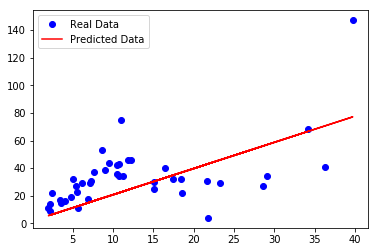

In [8]:
# Plot the results    
X, Y = data.T[0], data.T[1]
plt.plot(X, Y, 'bo', label='Real Data')
plt.plot(X, X * w_hat + b_hat, 'r', label='Predicted Data')
plt.legend()
plt.show()

### NEW

In [9]:
def read_birth_life_data(filename):
    """
    Read in birth_life_2010.txt and return:
    data in the form of NumPy array
    n_samples: number of samples
    """
    text = open(filename, 'r').readlines()[1:]
    data = [line[:-1].split('\t') for line in text]
    births = [float(line[1]) for line in data]
    lifes = [float(line[2]) for line in data]
    data = list(zip(births, lifes))
    n_samples = len(data)
    data = np.asarray(data, dtype=np.float32)
    return data, n_samples

In [10]:
## NEW

DATA_FILE_NEW = './data/birth_life_2010.txt'

# Step 1: Read in the data from .txt file
data, n_samples = read_birth_life_data(DATA_FILE_NEW)

# Step 2: Create placeholders for X (birth rate) and Y (life expectancy)
X = tf.placeholder(dtype=tf.float32, name='X')
Y = tf.placeholder(dtype=tf.float32, name='Y')

# Step 3: Create weights and bias, initialized to 0.0
w = tf.get_variable(name='w_new', initializer=tf.constant(0.0))
b = tf.get_variable(name='b_new', initializer=tf.constant(0.0))

# Step 4: Build model to predict Y
Y_pred = tf.add(tf.multiply(w, X), b)

# Step 5: Use square error as the loss function
loss = tf.square(Y - Y_pred, name='loss')

# Step 6: Using gradient descent with learning rate = 0.001 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

start = time.time()

# Create a filewriter to write the models graph for TensorBoard
writer = tf.summary.FileWriter('./graphs/linear_reg', graph=tf.get_default_graph())

with tf.Session() as sess:
    
    # Step 7: Initialize the necessary variables
    sess.run(tf.global_variables_initializer())
    
    # Step 8: Train the model for 100 epochs
    for i in range(100):
        total_loss = 0
        for x, y in data:
            # Execute the train_op and get the value of loss
            _, l = sess.run([optimizer, loss], feed_dict={X:x, Y:y})
            total_loss += l
            
        print('Epoch {}: {}'.format(i, total_loss/n_samples))
        
        # Cloe the writer
        writer.close()
        
        # Step 9: Output the values of w and b
        w_out, b_out = sess.run([w, b])
        
print('Took: {} seconds'.format(time.time() - start))

Epoch 0: 1661.86378346
Epoch 1: 956.322414861
Epoch 2: 844.673702398
Epoch 3: 750.731248601
Epoch 4: 667.659834101
Epoch 5: 594.141771563
Epoch 6: 529.078781031
Epoch 7: 471.500419149
Epoch 8: 420.545862646
Epoch 9: 375.45530722
Epoch 10: 335.554302519
Epoch 11: 300.24629858
Epoch 12: 269.003764758
Epoch 13: 241.359574669
Epoch 14: 216.900391353
Epoch 15: 195.259722981
Epoch 16: 176.113769361
Epoch 17: 159.175516934
Epoch 18: 144.190711113
Epoch 19: 130.935034881
Epoch 20: 119.209356611
Epoch 21: 108.837930981
Epoch 22: 99.6646676062
Epoch 23: 91.5517701303
Epoch 24: 84.3766404678
Epoch 25: 78.03217825
Epoch 26: 72.4218292781
Epoch 27: 67.4613623949
Epoch 28: 63.0756695237
Epoch 29: 59.1987414652
Epoch 30: 55.7716844638
Epoch 31: 52.7426982236
Epoch 32: 50.0656327809
Epoch 33: 47.7000642163
Epoch 34: 45.6101790212
Epoch 35: 43.7637975063
Epoch 36: 42.132592211
Epoch 37: 40.6922193933
Epoch 38: 39.4202198634
Epoch 39: 38.2970086453
Epoch 40: 37.3055917595
Epoch 41: 36.4306634161
Epoch 4

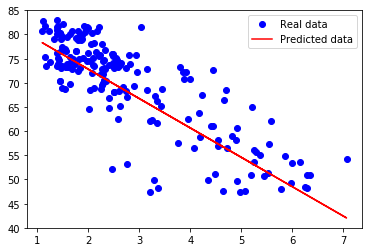

In [11]:
# plot the results
plt.plot(data[:,0], data[:,1], 'bo', label='Real data')
plt.plot(data[:,0], data[:,0] * w_out + b_out, 'r', label='Predicted data')
plt.legend()
plt.show()

In [12]:
def huber_loss_n(Y_true, Y_pred, delta=1.0):
    """
    Huber loss function
    """
    # Calculate absolute residual
    residual = tf.abs(Y_true - Y_pred)
    
    def f1(): return 0.5 * tf.square(residual)
    
    def f1(): return delta * residual - 0.5 * tf.square(delta)
    
    return tf.cond(residual < delta, true_fn=f1, false_fn=f2)

**TensorFlow Control Flow**

- Control Flow Operations: `tf.group`, `tf.count_up_to`, `tf.cond`, `tf.case`, `tf.while_loop`, ...
- Comparison Operations: `tf.equal`, `tf.not_equal`, `tf.less`, `tf.greater`, `tf.where`, ...
- Logical Operations: `tf.logical_and`, `tf.logica_not`, `tf.logical_or`, ...
- Debugging Operations: `tf.is_finite`, `tf.is_inf`, `tf.is_nan`, `tf.Assert`, `tf.Print`, ...

## `tf.data`

**`tf.placeholder`**
- Advantage: Puts the data processing outside TensorFlow, making it easy to do in Python
- Disadvantage: Users often end up processing their data in a single thread and creating data bottleneck that slows execution down.
- For prototyping `feed_dict` can be faster and easier to write (pythonic)
    
**`tf.data`** - Instead of doing inference with placeholders and feeding in data later, it allows to do inference directly with data. It is tricky to use when there are complicated preprocessing steps or multiple data sources. `tf.data` performs better than `tf.placeholder`
- Older version of TensorFlow (1.2.0): `tf.contrib.data`
- Newer version of TensorFlow (1.4.0 or later): `tf.data`

---

Store data in **`tf.data.Dataset`**
- `tf.data.Dataset.from_tensor_slices((features, labels))`
- `tf.data.Dataset.from_generator(gen, output_types, output_shapes)`

Create `Dataset` from files
- `tf.data.TextLineDataset(filenames)`
- `tf.data.FixedLengthRecordDataset(filenames)`
- `tf.data.TFRecordDataset(filenames)`

---

**`tf.data.Iterator`** - Creates and iterator to iterate through samples in `Dataset`

In [13]:
# Read in the data from .txt file
data, n_samples = read_birth_life_data(DATA_FILE_NEW)

# Store data in tf.data.Dataset
# dataset = tf.contrib.data.Dataset.from_tensor_slices((data[:,0], data[:, 1]))
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:, 1]))

print('Output types: ', dataset.output_types)
print('Output shapes: ', dataset.output_shapes)
print(dataset)

('Output types: ', (tf.float32, tf.float32))
('Output shapes: ', (TensorShape([]), TensorShape([])))
<TensorSliceDataset shapes: ((), ()), types: (tf.float32, tf.float32)>


In [14]:
# Create iterator: Iterate through the dataset exactly once. No need to initialize
iterator = dataset.make_one_shot_iterator()

X, Y = iterator.get_next()

with tf.Session() as sess:
    print('Birth rate and life expectancy: ', sess.run([X, Y]))
    print('Birth rate and life expectancy: ', sess.run([X, Y]))
    print('Birth rate and life expectancy: ', sess.run([X, Y]))

('Birth rate and life expectancy: ', [1.822, 74.82825])
('Birth rate and life expectancy: ', [3.869, 70.81949])
('Birth rate and life expectancy: ', [3.911, 72.15066])


In [15]:
# Create iterator: Iterate through the dataset as many times as we want. 
# Need to initialize with each epoch
iterator = dataset.make_initializable_iterator()

with tf.Session() as sess:
    for i in range(3):
        sess.run(iterator.initializer)
        X, Y = iterator.get_next()
        print('Birth rate and life expectancy: ', sess.run([X, Y]))

('Birth rate and life expectancy: ', [1.822, 74.82825])
('Birth rate and life expectancy: ', [1.822, 74.82825])
('Birth rate and life expectancy: ', [1.822, 74.82825])


In [16]:
# Handling data in TensorFlow: Shuffle elements of dataset
dataset = dataset.shuffle(10)
iterator = dataset.make_one_shot_iterator()

X, Y = iterator.get_next()

with tf.Session() as sess:
    print('Birth rate and life expectancy: ', sess.run([X, Y]))
    print('Birth rate and life expectancy: ', sess.run([X, Y]))
    print('Birth rate and life expectancy: ', sess.run([X, Y]))

('Birth rate and life expectancy: ', [3.951, 62.44061])
('Birth rate and life expectancy: ', [5.578, 61.999855])
('Birth rate and life expectancy: ', [1.579, 73.92766])


In [17]:
# Handling data in TensorFlow: Repeat dataset `count` times
dataset = dataset.repeat(count=3)
iterator = dataset.make_one_shot_iterator()

X, Y = iterator.get_next()

with tf.Session() as sess:
    print('Birth rate and life expectancy: ', sess.run([X, Y]))
    print('Birth rate and life expectancy: ', sess.run([X, Y]))
    print('Birth rate and life expectancy: ', sess.run([X, Y]))

('Birth rate and life expectancy: ', [1.579, 73.92766])
('Birth rate and life expectancy: ', [4.229, 67.465195])
('Birth rate and life expectancy: ', [2.141, 76.30168])


In [18]:
# Handling data in TensorFlow: Batch combines consecutive elements of dataset into batches
dataset = dataset.batch(2)
iterator = dataset.make_one_shot_iterator()

X, Y = iterator.get_next()

with tf.Session() as sess:
    print('Birth rate and life expectancy: ', sess.run([X, Y]))

('Birth rate and life expectancy: ', [array([1.15 , 3.911], dtype=float32), array([81.641464, 72.15066 ], dtype=float32)])


In [20]:
# # # Handling data in TensorFlow: Convert each element of dataset to one hot vector
# dataset = dataset.map(lambda x: tf.one_hot(x, 10))
# iterator = dataset.make_one_shot_iterator()

# X, Y = iterator.get_next()

# with tf.Session() as sess:
#     print('Birth rate and life expectancy: ', sess.run([X, Y]))

**Optimizers**
- How does TensorFlow know what `Variables` to update? - *Session looks at all trainable `Variables` that loss depends on and update them*
    - `tf.Variable(initial_value=None, trainable=True, ...)` - Specify if a `Variable` should be trained or not. By default all `Variables` are trainable
    
    
- `tf.train.GradientDescentOptimizer`
- `tf.train.AdagradOptimizer`
- `tf.train.MomentumOptimizer`
- `tf.train.AdamOptimizer`
- `tf.train.FtrlOptimizer` - Follow The Regularized Leader (FTLR) algorithm
- `tf.train.RMSPropOptimizer`
- Others

**Logistic Regression**

Each image in the MNIST data is of shape $28\times28$ = 784, and each image is represented with a 1x784 tensor. There are 10 classes for each image, corresponding to digits 0 - 9. Features are of the type float, and labels are of the type int

$$logit(p_i) = WX + b$$

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# TF data
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
# 1. Assemble the graph
# ---------------------
batch_size = 64
learning_rate = 0.01
n_epochs = 10

# 1.1 Read the data
mnist = input_data.read_data_sets('./data/mnist', one_hot=True) 
print('Training set size: ', mnist.train.num_examples)
print('Validation set size: ', mnist.validation.num_examples)
print('Testing set size: ', mnist.test.num_examples)

# 1.2 Create placeholders for features and labels
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, 784], name='image')
Y = tf.placeholder(dtype=tf.int32, shape=[batch_size, 10], name='label')

# 1.3 Create Variables for weight and bias, initialized to 0.0
w = tf.Variable(initial_value=tf.random_normal([784, 10], stddev=0.01), name='w')
b = tf.Variable(initial_value=tf.zeros([1, 10]), name='b')

# 1.4 Build model: logits = w * X + b
logits = tf.add(tf.matmul(X, w), b)

# 1.5 Specify loss function: softmax cross-entropy with logits
entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)
loss = tf.reduce_mean(entropy)

# 1.6 Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
('Training set size: ', 55000)
('Validation set size: ', 5000)
('Testing set size: ', 10000)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [4]:
# 2. Train the model
# ------------------

# Session looks at all trainable variables that loss depends on and updates them
with tf.Session() as sess:
    
    # 2.1 Initialize the nessary variables
    sess.run(tf.global_variables_initializer())
    
    n_batches = int(mnist.train.num_examples/batch_size)
    
    # Write file for tensorboard
    writer = tf.summary.FileWriter('./graphs/logistic_reg', sess.graph)
    
    # 2.2 Training
    for i in range(n_epochs): # Train the model n_epochs times
        total_loss = 0
        
        for _ in range(n_batches):
            X_batch, Y_batch = mnist.train.next_batch(batch_size)
            _, batch_loss = sess.run([optimizer, loss], feed_dict={X: X_batch, Y: Y_batch})
            total_loss += batch_loss
            
        print("Epoch {0}: Loss: {1}".format(i, total_loss/n_batches))
            
    # Close writer
    writer.close()
    
    # Test the model
    preds = tf.nn.softmax(logits) # logits = w * X + b
    correct_preds = tf.equal(tf.argmax(preds, axis=1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    
    test_batches = int(mnist.test.num_examples/batch_size)
    total_correct_preds = 0
    for _ in range(test_batches):
        X_batch, Y_batch = mnist.test.next_batch(batch_size)
        batch_accuracy = sess.run(accuracy, feed_dict={X: X_batch, Y: Y_batch})
        total_correct_preds += batch_accuracy
    print('Accuracy: {0}'.format(total_correct_preds/mnist.test.num_examples))

Epoch 0: Loss: 1.01287171678
Epoch 1: Loss: 0.568997292878
Epoch 2: Loss: 0.484952754761
Epoch 3: Loss: 0.444337416826
Epoch 4: Loss: 0.418568809804
Epoch 5: Loss: 0.401270660102
Epoch 6: Loss: 0.38780995036
Epoch 7: Loss: 0.377164614891
Epoch 8: Loss: 0.36884212912
Epoch 9: Loss: 0.361598125905
Accuracy: 0.0141890625


### NEW
- Using **`tf.data`** instead of `feed_dict`

In [6]:
import gzip
import shutil
import struct
import urllib


def safe_mkdir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

    
def download_one_file(download_url, 
                    local_dest, 
                    expected_byte=None, 
                    unzip_and_remove=False):
    """ 
    Download the file from download_url into local_dest
    if the file doesn't already exists.
    If expected_byte is provided, check if 
    the downloaded file has the same number of bytes.
    If unzip_and_remove is True, unzip the file and remove the zip file
    """
    if os.path.exists(local_dest) or os.path.exists(local_dest[:-3]):
        print('%s already exists' %local_dest)
    else:
        print('Downloading %s' %download_url)
        local_file, _ = urllib.request.urlretrieve(download_url, local_dest)
        file_stat = os.stat(local_dest)
        if expected_byte:
            if file_stat.st_size == expected_byte:
                print('Successfully downloaded %s' %local_dest)
                if unzip_and_remove:
                    with gzip.open(local_dest, 'rb') as f_in, open(local_dest[:-3],'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                    os.remove(local_dest)
            else:
                print('The downloaded file has unexpected number of bytes')

                
def download_mnist(path):
    """ 
    Download and unzip the dataset mnist if it's not already downloaded 
    Download from http://yann.lecun.com/exdb/mnist
    """
    safe_mkdir(path)
    url = 'http://yann.lecun.com/exdb/mnist'
    filenames = ['train-images-idx3-ubyte.gz',
                'train-labels-idx1-ubyte.gz',
                't10k-images-idx3-ubyte.gz',
                't10k-labels-idx1-ubyte.gz']
    expected_bytes = [9912422, 28881, 1648877, 4542]

    for filename, byte in zip(filenames, expected_bytes):
        download_url = os.path.join(url, filename)
        local_dest = os.path.join(path, filename)
        download_one_file(download_url, local_dest, byte, True)

        
def parse_data(path, dataset, flatten):
    if dataset != 'train' and dataset != 't10k':
        raise NameError('dataset must be train or t10k')

    label_file = os.path.join(path, dataset + '-labels-idx1-ubyte')
    with open(label_file, 'rb') as file:
        _, num = struct.unpack(">II", file.read(8))
        labels = np.fromfile(file, dtype=np.int8) #int8
        new_labels = np.zeros((num, 10))
        new_labels[np.arange(num), labels] = 1
    
    img_file = os.path.join(path, dataset + '-images-idx3-ubyte')
    with open(img_file, 'rb') as file:
        _, num, rows, cols = struct.unpack(">IIII", file.read(16))
        imgs = np.fromfile(file, dtype=np.uint8).reshape(num, rows, cols) #uint8
        imgs = imgs.astype(np.float32) / 255.0
        if flatten:
            imgs = imgs.reshape([num, -1])

    return imgs, new_labels


def read_mnist(path, flatten=True, num_train=55000):
    """
    Read in the mnist dataset, given that the data is stored in path
    Return two tuples of numpy arrays
    ((train_imgs, train_labels), (test_imgs, test_labels))
    """
    imgs, labels = parse_data(path, 'train', flatten)
    indices = np.random.permutation(labels.shape[0])
    train_idx, val_idx = indices[:num_train], indices[num_train:]
    train_img, train_labels = imgs[train_idx, :], labels[train_idx, :]
    val_img, val_labels = imgs[val_idx, :], labels[val_idx, :]
    test = parse_data(path, 't10k', flatten)
    return (train_img, train_labels), (val_img, val_labels), test

In [7]:
# Define parameters for the model
learning_rate = 0.01
batch_size = 128
n_epochs = 30
n_train = 60000 # 55K train + 5K val
n_test = 10000

In [11]:
# Step 1: Read the MNIST data
mnist_dir = '/Users/Ankoor/Desktop/dmedNotebooks/TF/data/MNIST'

# Download MNIST data
download_mnist(mnist_dir)

# Read data
train, val, test = read_mnist(mnist_dir, flatten=True)

Successfully downloaded /Users/Ankoor/Desktop/dmedNotebooks/TF/data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded /Users/Ankoor/Desktop/dmedNotebooks/TF/data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded /Users/Ankoor/Desktop/dmedNotebooks/TF/data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded /Users/Ankoor/Desktop/dmedNotebooks/TF/data/MNIST/t10k-labels-idx1-ubyte.gz


In [12]:
# Step 2: Create datasets and iterator

# Create training dataset and batch it
train_data = tf.data.Dataset.from_tensor_slices(train)
train_data = train_data.shuffle(10000)
train_data = train_data.batch(batch_size)

# Create testing dataset and batch it
test_data = tf.data.Dataset.from_tensor_slices(test)
test_data = test_data.batch(batch_size)

# Create one iterator and initialize it with different datasets
iterator = tf.data.Iterator.from_structure(train_data.output_types, 
                                                   output_shapes=train_data.output_shapes)

# Initializers for datasets
train_init = iterator.make_initializer(train_data)
test_init = iterator.make_initializer(test_data)

X, y = iterator.get_next()

In [13]:
# Step 3: Create weights and bias
w = tf.get_variable(name='w_log', shape=[784, 10], initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
b = tf.get_variable(name='b_log', shape=[1, 10], initializer=tf.constant_initializer(0.0))

In [16]:
# Step 4: Build model which returns logits (logits = w * X + b)
# Logits will be later passed through softmax layer
logits = tf.add(tf.matmul(X, w), b)

In [20]:
# Step 5: Define loss function (use cross entropy of softmax of logits)
x_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf.stop_gradient(y), name='xentropy')
loss = tf.reduce_mean(x_entropy, name='loss')

In [18]:
# Step 6: Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [22]:
# Step 7: Calculate accuracy with test set
preds = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(preds, axis=1), tf.argmax(y, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

In [23]:
# Step 8: Train the model
writer = tf.summary.FileWriter('./graphs/logreg', tf.get_default_graph())

with tf.Session() as sess:
    start_time = time.time()
    
    # Initialize all weights
    sess.run(tf.global_variables_initializer())
    
    # Train model for n_epoch times
    for i in range(n_epochs):
        
        sess.run(train_init)  # Draw samples from train data
        
        total_loss = 0
        n_batches = 0
        
        try:
            while True:
                _, ll = sess.run([optimizer, loss])
                total_loss += ll
                n_batches += 1
        except tf.errors.OutOfRangeError:
            pass
        print('Average loss in epoch {}: {}'.format(i, total_loss/float(n_batches)))
    print('Total time: {} seconds'.format(time.time() - start_time))
    
    # Test model
    sess.run(test_init)  # Draw samples from test data
    total_correct_preds = 0
    
    try:
        while True:
            batch_accuracy = sess.run(accuracy)
            total_correct_preds += batch_accuracy
    except tf.errors.OutOfRangeError:
        pass
    
    print('Accuracy {}'.format(total_correct_preds/n_test))
writer.close()

Average loss in epoch 0: 0.3670748881822409
Average loss in epoch 1: 0.29420908637518106
Average loss in epoch 2: 0.285269708948773
Average loss in epoch 3: 0.27726744685408683
Average loss in epoch 4: 0.2757281856481419
Average loss in epoch 5: 0.27146128083384313
Average loss in epoch 6: 0.26844038939060166
Average loss in epoch 7: 0.26739977388534436
Average loss in epoch 8: 0.2643032164247923
Average loss in epoch 9: 0.26269317208681
Average loss in epoch 10: 0.2620549042211022
Average loss in epoch 11: 0.25947207304280856
Average loss in epoch 12: 0.2608996241764967
Average loss in epoch 13: 0.2582457341773565
Average loss in epoch 14: 0.2583241242828757
Average loss in epoch 15: 0.2596906771146974
Average loss in epoch 16: 0.2542833355970161
Average loss in epoch 17: 0.2569869753059953
Average loss in epoch 18: 0.2547457960109378
Average loss in epoch 19: 0.25645982364929
Average loss in epoch 20: 0.2539535453153211
Average loss in epoch 21: 0.2529122515646524
Average loss in epo